# Reinforcement Learning

Today's topic, Reinforcement Learning, gets us close to what people might traditionally imagine when they hear "artificial intelligence." You might not instinctively call a network that identifies handwritten digits "intelligent", but you might apply that word to a program that learns to play chess or a robot that figures out how to walk. Reinforcement Learning (RL) is a subfield of machine learning that tackles precisely these kinds of problems - where an agent learns to act intelligently through interaction with its environment.

## Core Concepts
Think of reinforcement learning like teaching a dog a trick - the dog (agent) interacts with its surroundings (environment), and through trial and error, it figures out which actions lead to good outcomes (treats).

The essential components of RL:
- an *agent* is exploring an *environment.*
- at any given time, the agent perceives a *state* of the environment, $s\in S$.
- the agent can take *actions*, $a\in A$, that influence the environment and move it to a new state.

### Policy Function
How does the agent decide what action to take? This is governed by a policy $\pi: \rightarrow A$, a function that maps states to actions. The policy might be *deterministic* or *stochastic*, conditioned on the state.

As the agent follows its policy, it generates a trajectory through state space - a sequence of states and actions. This trajectory either continues indefinitely or ends in a terminal state, such as winning a games or reaching a physical goal.

### Rewards and Return
At each time step $t$, the agent receives a reward $r_t$, which is a number that tells it how "good" or "bad" the outcome of its action was. These rewards accumulate into a *return*:
$$G_t = \Sigma_0^{\inf} \gamma^k r_{t+k+1}.$$
Here, $\gamma \in[0,1]$ is a *discount factor* that controls how much the agent values future rewards. A $gamma$ close to 0 makes the agent short-sighted; a $gamma$ close to 1 makes it value long-term planning.

### Value Functions
To help the agent evaluate decisions, we define:
- *state value function(s)* - $v_\pi(s) = \mathbb{E}_\pi[G_t|S_t=s]$. This is the expected return if the agent starts in state $s$ and follows policy $\pi$
- *action value function(s)* - $q_{\pi}(s,a) = \mathbb{E}_\pi[G_t|S_t=s,A_t=a]$. This tells us how good it is to take action $a$ in state $s$, assuming we follow policy $\pi$ thereafter. 

## The Goal of RL
The ultimate goal is to find a policy $\pi$ that maximizes expected return over time. Two major methods are used:
- Value-based methods: First estimate $v_{\pi}(s)$ or $q_\pi(s,a)$, then derive the policy from it.
- Policy-based methods: Directly optimize the policy to maximize expected return. these are often called policy gradient methods.

## When to use RL
To decide whether reinforcment learning is the right approach for your problem, you should ask: 
- Is there a natural framing in terms of an agent exploring an environment?
- Can the agent take discrete or continuous actions that affect outcomes?
- Is there a clear notion of reward? What counts as good or bad?
If so, RL may be appropriate

In some simple environments (like in small grids or short games), you can exhaustively try all possible states and actions. But in complex environments with huge state spaces (think Chess, Go, or String Theory parameter landscapes), brute force becomes unrealistic. In those cases, we use function approximation - usually using neural networks - to estimate value functions or policies. This gives rise to the modern and powerful field of *deep reinforcement learning*

For more on RL, see:
- [Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html), a famous early textbook.
- [David Silver's course](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html), a more modern take. The videos were my entry point into RL.
- [AlphaZero](https://www.nature.com/articles/nature24270), a 2017 breakthrough in which RL achieves superhuman gameplay in Go *without human knowledge*, i.e. only via knowledge of the game and self-play. It was extended to Chess and Shogi in 2018. See the arXiv article here: [Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm](https://arxiv.org/abs/1712.01815).
- My friends and I introduced RL into string theory in [Branes with Brains](https://arxiv.org/abs/1903.11616). We have also used it to [find unknots](https://arxiv.org/abs/2010.16263) and [ribbons](https://arxiv.org/abs/2304.09304), the latter in connection with the smooth 4d Poincaré conjecture.


# Gridworld

In this class we'll study a famous game in RL called *Gridworld*, see. e.g. Sutton and Barto for more. It's a simple game that is easy to understand, but still has some interesting features. The game is played on a grid, and the agent can move up, down, left, or right. The agent starts in a random position, and the goal is to reach the goal state, which is chosen via the policy.
The game ends when the agent reaches the goal.

First we'll set up some helper functions that will be used below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# get the best action. If several actions are equally good, choose a random one
def get_best_action(dct):
    best_actions = []
    max_key = None
    max_val = float('-inf')
    for k, v in dct.items():
        if v > max_val:
            max_val = v
            max_key = k
            best_actions = [[max_key, max_val]]
        elif v == max_val:
            best_actions.append([k, v])

    return best_actions[np.random.randint(0, len(best_actions))]

# randomize the action in 100*eps percent of the cases
def random_action(action, action_space, eps=0.3):
    p = np.random.random()
    if p < (1 - eps):
        return action
    else:
        return np.random.choice(action_space)

# Animate the steps taken, ignore this if you don't care
step_counter = 0
explore_step = None
def animate_steps(agent, window_title, fig_title=""):
    plt.ioff()
    fig = plt.figure(window_title)
    fig.suptitle(fig_title)
    mySteps = agent.steps_taken
    agent.reset()
    step_counter = 0
    explore_step = mySteps[step_counter]
    im = plt.imshow(agent.render_world(), animated=True)

    def update_fig(*args):
        nonlocal explore_step, step_counter
        if step_counter < len(mySteps):
            explore_step = mySteps[step_counter]
        else:
            step_counter = 0
            explore_step = mySteps[step_counter]
            agent.reset()
        agent.step(explore_step, False)
        step_counter += 1
        im.set_array(agent.render_world())
        plt.draw()
        return im,

    ani = animation.FuncAnimation(fig, update_fig, interval=150, blit=True, frames=len(mySteps)-1, repeat=True)
    plt.axis("off")
    plt.title(window_title)
    # plt.show()
    ani.save("videos/"+window_title + ".gif", writer=animation.PillowWriter(fps=5))


## Defining Gridworld
This module defines the Gridworld game environment.

In [3]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import scipy.ndimage

# The gridworld environment
class GameEnv:
    def __init__(self):
        # initialization of the world
        self.sizeX = 12
        self.sizeY = 12
        self.state = ()  # A state in gridworld is just the (x,y) coordinate pair of the worker
        plt.ioff()  # there is currently a bug for Mac users which requires turning this off (as of Fall '24)
        self.world_canvas = plt.figure("Gridworld")
        self.world_canvas.suptitle('Blue: Worker, Red: Pitfalls, Green: Exit')
        self.im = None
        plt.axis("off")
        self.objects = []
        self.initial_x = 0
        self.initial_y = 0
        self.gave_up = False

        # We want the worker to solve the maze as fast as possible without falling into the pits:
        # *)   -1 for each step (penalty to solve it quickly)
        # *)  -50 for each pitfall (penalty for falling into the pit)
        # *) +100 for finding the exit (reward for solving the maze)
        # *)   -2 for running into a wall / not moving at all
        self.step_penalty = -1.
        self.pitfall_penalty = -50.
        self.exit_reward = 100.
        self.no_move_penalty = -2.

        # Actions in gridworld: move up, down, left, right
        self.action_space = [0, 1, 2, 3]  # up, down, left, right

        # keep track of the total number of steps and the steps that were taken in the game
        self.steps = 0
        self.steps_taken = []

        # maximal number of steps before we give up solving the maze
        self.max_steps = 100

        # initialize and plot the world
        self.world = self.initialize_world()

    # initialize a new random world
    def initialize_world(self):
        self.objects = []

        # 1.) The first parameter is the name of the object
        # 2.) The second parameter is the reward / penalty:
        # 3.) The third parameter is the position of the object in the world
        # 4.) Ignore the other parameters, they are just used for drawing the world (box sizes and color)
        maze_exit = GameOb('exit', self.exit_reward, self.new_position(), 1, [0, 1, 0, 1])
        self.objects.append(maze_exit)
        worker = GameOb('worker', None, self.new_position(), 1, [0, 0, 1, 1])
        self.objects.append(worker)
        for i in range(6):  # add pitfalls
            pitfall = GameOb('pitfall', self.pitfall_penalty, self.new_position(), 1, [1, 0, 0, 1])
            self.objects.append(pitfall)

        # store the initial (x,y) coordinates for a reset
        self.initial_x = worker.x
        self.initial_y = worker.y

        # show the world
        world = self.render_world()

        # initialize/reset the variables
        self.reset()

        # plot the world
        plt.ioff()
        self.im = plt.imshow(world, interpolation="nearest")

        return world

    # reset the world to its initial configuration, ignore this
    def reset(self):
        self.steps = 0
        self.steps_taken = []
        self.gave_up = False
        self.state = (self.initial_x, self.initial_y)
        for obj in self.objects:
            if obj.name == 'worker':
                obj.x = self.initial_x
                obj.y = self.initial_y
                break

    # move through the world
    # 0 - up, 1 - down, 2 - left, 3 - right
    def move_worker(self, direction):

        # identify the worker amongst the gridworld objects
        worker = None
        others = []
        for obj in self.objects:
            if obj.name == 'worker':
                worker = obj
            else:
                others.append(obj)

        worker_x = worker.x
        worker_y = worker.y

        # overall reward/penalty
        reward = self.step_penalty  # penalize each move

        # update the position of the worker in gridworld (move if possible)
        if direction == 0 and worker.y >= 1:
            worker.y -= 1
        if direction == 1 and worker.y <= self.sizeY - 2:
            worker.y += 1
        if direction == 2 and worker.x >= 1:
            worker.x -= 1
        if direction == 3 and worker.x <= self.sizeX - 2:
            worker.x += 1

        # move was illegal
        if worker.x == worker_x and worker.y == worker_y:
            reward = self.no_move_penalty

        # update to new position
        for i in range(len(self.objects)):
            if self.objects[i].name == 'worker':
                self.objects[i] = worker
                break

        # check whether new field is a special field (exit/pitfall) and compute reward/penalty
        is_maze_solved = False
        for other in others:
            if worker.x == other.x and worker.y == other.y:  # the worker ran into an object
                if other.name == "exit":  # the object was an exit
                    is_maze_solved = True
                    reward = other.reward
                    break  # we can exit the loop here since we can only run into one object
                elif other.name == "pitfall":  # the object was a pitfall
                    is_maze_solved = False
                    reward = other.reward
                    break   # we can exit the loop here since we can only run into one object

        return reward, is_maze_solved

    # perform the step, collect the reward, check whether you have reached the exit
    def step(self, action, update_view=True):

        # collect the reward/punishment for the field the worker ends up in and check whether the exit was reached
        reward, done = self.move_worker(action)

        self.steps += 1
        self.steps_taken.append(action)

        # give up
        if self.steps >= self.max_steps and not done:
            done = True
            self.gave_up = True

        # this just updates the graphic output of the world
        if update_view:
            self.im.set_array(self.render_world())
            plt.draw()

        # return the new state, the penalty/reward for the move and whether gridworld is solved/given up on
        return self.get_state(), reward, done

    # get the current state
    def get_state(self):
        for obj in self.objects:
            if obj.name == 'worker':
                return (obj.x, obj.y)

    # check whether an action is possible, i.e. whether a wall is blocking the way
    def is_possible_action(self, action):
        is_possible = False
        if action == 0 and self.state[1] >= 1:
            is_possible = True
        if action == 1 and self.state[1] <= self.sizeY - 2:
            is_possible = True
        if action == 2 and self.state[0] >= 1:
            is_possible = True
        if action == 3 and self.state[0] <= self.sizeX - 2:
            is_possible = True

        return is_possible

    ####################################################################################################################
    # ignore the code from here on, it just draws the world and represents the objects in the game.
    ####################################################################################################################
    def close_world_display(self):
        plt.close("Gridworld")

    def new_position(self):
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        current_position = []
        for objectA in self.objects:
            if (objectA.x, objectA.y) not in current_position:
                current_position.append((objectA.x, objectA.y))
        for pos in current_position:
            points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]

    def render_world(self):
        a = np.zeros([self.sizeY + 2, self.sizeX + 2, 4])
        a[0:, 0, 3] = 1  # left wall
        a[0, 0:, 3] = 1  # top wall
        a[0:, self.sizeX + 1, 3] = 1  # right wall
        a[self.sizeY + 1, 0:, 3] = 1  # bottom wall
        a[1:-1, 1:-1, :] = 1
        for item in self.objects:
            if a[item.y + 1, item.x + 1, 0] == 1 and a[item.y + 1, item.x + 1, 1] == 1 and a[item.y + 1, item.x + 1, 2] == 1:  # is completely white
                for i in range(len(item.channel)): a[item.y + 1:item.y + item.size + 1, item.x + 1:item.x + item.size + 1, i] = item.channel[i]
            else:  # other object on the field, overlay worker with pitfalls / exit
                for i in range(len(item.channel)):
                    if a[item.y + 1, item.x + 1, i] == 0:
                        a[item.y + 1:item.y + item.size + 1, item.x + 1:item.x + item.size + 1, i] += item.channel[i]
        a = scipy.ndimage.zoom(a[:, :], (4, 4, 1), order=0, mode="nearest")
        return a

# This represents an object in the game: worker, pitfall, exit
class GameOb:
    def __init__(self, name, reward, coordinates, size, RGBA):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.channel = RGBA
        self.reward = reward
        self.name = name


Now we have the agent explore Gridworld. Since the state space is small, we can explore the entire environment and find optimal policies. We will do so using an algorithm called *SARSA*. The basic idea is to estimate the action-value function $q_\pi(s,a)$, and then use it to find the optimal policy. The algorithm is as follows:
Initialize $Q(s,a)$ arbitrarily.
  

## Implementing Gridworld
Based on a SARSA implementation downloaded at [sarsa.py](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rl/sarsa.py). It was further modified by Fabian Ruehle. Below, we initialize the environment, train the agent, and solve the puzzle.

I moved up
I moved down
I moved left
I moved right


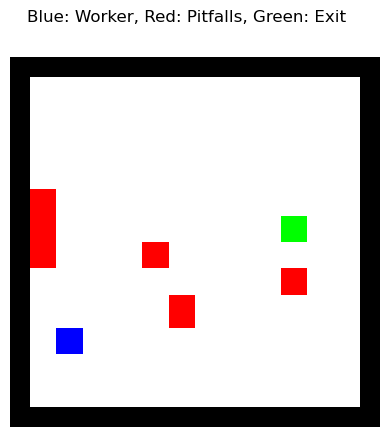

In [5]:
# Based on a SARSA implementation downloaded from 
# Modified and extended by Fabian Ruehle

# Explore Gridworld
# import gridworld
# import helperFunctions
import matplotlib.pyplot as plt

# Gridworld:
# *) Worker:    Blue
# *) Pitfalls:  Red
# *) Exit:      Green
agent = GameEnv()

agent.step(0)
print("I moved up")
agent.step(1)
print("I moved down")
agent.step(2)
print("I moved left")
agent.step(3)
print("I moved right")

### Part 1: Play the game once to see an untrained agent at work

In [15]:
agent.reset()
agent.close_world_display()
print("Let the game begin...")

# generate all states
all_states = []
for x in range(agent.sizeX):
    for y in range(agent.sizeY):
        all_states.append((x, y))

# Q is a dictionary that contains the rewards for all four actions that can be performed in any given square of Gridworld.
# Initialize Q and keep track of how many times Q[s] has been updated
Q = {}
update_counts_sa = {}
for s in all_states:
    update_counts_sa[s] = {}
    Q[s] = {}
    for a in agent.action_space:
        update_counts_sa[s][a] = 1.0
        Q[s][a] = 0.0

gamma = 0.9  # discount factor
alpha_W = 0.1  # learning rate
t = 1.0  # count time

########################################################################################################################

# To start the algorithm, we need any action, so we pick one randomly until we find a valid action which we perform
found_initial_move = False
current_action = None
current_state = agent.get_state()
while not found_initial_move:
    current_action = random_action(None, agent.action_space, eps=1)
    found_initial_move = agent.is_possible_action(current_action)

episode_reward = 0
q_update_log = []
# loop until done (i.e. solved the maze or gave up)
done = False
while not done:
    # perform the current step and get the next state, the reward/penalty for the move, and whether the agent is done (solved or gave up)
    next_state, reward, done = agent.step(current_action, False)

    # get the best currently known action for the state we are in now
    next_action = get_best_action(Q[current_state])[0]
    # randomize the action to allow for exploration. As time progresses, make random actions less likely.
    next_action = random_action(next_action, agent.action_space, eps=0.4/t)
    # Log pre-update Q-value
    old_q = Q[current_state][current_action]
    # Update Q
    alpha = alpha_W / update_counts_sa[current_state][current_action]
    update_counts_sa[current_state][current_action] += 0.005
    Q[current_state][current_action] = Q[current_state][current_action] + alpha * (reward + gamma * Q[next_state][next_action] - Q[current_state][current_action])
    #Log info
    new_q = Q[current_state][current_action]
    q_update_log.append((current_state, current_action, old_q, reward, new_q))
    episode_reward += reward
    # update current state, current action, and start over
    current_state = next_state
    current_action = next_action
    t += 0.001

print(f"Episode ended. Total reward: {episode_reward:.2f}")
print("Sample Q-updates (state, action, old Q, reward, new Q):")
for i, (s, a, old_q, r, new_q) in enumerate(q_update_log[10:]):  # limit to 5 for clarity
    print(f"  {i+1}: {s}, {a} → Q: {old_q:.2f} → {new_q:.2f} with reward {r}")

Let the game begin...
Episode ended. Total reward: -596.00
Sample Q-updates (state, action, old Q, reward, new Q):
  1: (0, 9), 2 → Q: 0.00 → -0.20 with reward -2.0
  2: (0, 9), 2 → Q: -0.20 → -0.39 with reward -2.0
  3: (0, 9), 3 → Q: -0.10 → -0.21 with reward -1.0
  4: (1, 9), 0 → Q: -0.19 → -0.28 with reward -1.0
  5: (1, 8), 3 → Q: -0.10 → -0.19 with reward -1.0
  6: (2, 8), 0 → Q: 0.00 → -0.10 with reward -1.0
  7: (2, 7), 1 → Q: 0.00 → -0.11 with reward -1.0
  8: (2, 8), 0 → Q: -0.10 → -0.19 with reward -1.0
  9: (2, 7), 3 → Q: 0.00 → -0.10 with reward -1.0
  10: (3, 7), 2 → Q: 0.00 → -0.10 with reward -1.0
  11: (2, 7), 0 → Q: 0.00 → -0.10 with reward -1.0
  12: (2, 6), 0 → Q: 0.00 → -0.10 with reward -1.0
  13: (2, 5), 1 → Q: 0.00 → -0.10 with reward -1.0
  14: (2, 6), 2 → Q: 0.00 → -0.10 with reward -1.0
  15: (1, 6), 2 → Q: 0.00 → -5.00 with reward -50.0
  16: (0, 6), 2 → Q: 0.00 → -5.00 with reward -50.0
  17: (0, 6), 2 → Q: -5.00 → -9.48 with reward -50.0
  18: (0, 6), 0 → 

### Part 2: Show the exploration route taken by the untrained worker

In [17]:
# show exploration route
result = ""
if not agent.gave_up:
    result = "I solved gridworld in " + str(agent.steps) + " steps."
else:
    result = "Sorry, I had to give up after " + str(agent.max_steps) + " steps."

# Animate the steps of the first game
print("Watch my exploration route... (close the plot window to continue)")
animate_steps(agent, "Gridworld exploration untrained worker", result)

from IPython.display import Image
Image(url='videos/Gridworld exploration untrained worker.gif')

Watch my exploration route... (close the plot window to continue)


### Part 3: Play the game 10,000 time to learn the best solution strategy

Now let me train for a while, I enjoyed the game so much!
I'm playing game 0 / 10000
I'm playing game 1000 / 10000
I'm playing game 2000 / 10000
I'm playing game 3000 / 10000
I'm playing game 4000 / 10000
I'm playing game 5000 / 10000
I'm playing game 6000 / 10000
I'm playing game 7000 / 10000
I'm playing game 8000 / 10000
I'm playing game 9000 / 10000
Ok, I am done practicing.


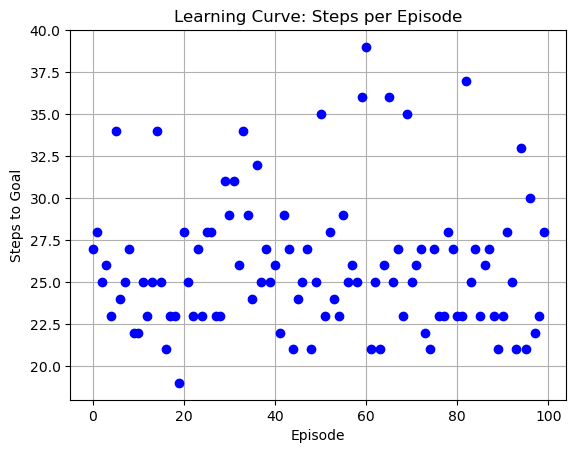

In [27]:
print("Now let me train for a while, I enjoyed the game so much!")
steps_per_episode = []

agent.reset()
plt.close('all')

# The code is essentially identical to the one used above, but now carried out 10,000 times
training_episodes = 10000
for i in range(training_episodes):
    if i % 1000 == 0:
        print("I'm playing game " + str(i) + " / " + str(training_episodes))
    if i % 100 == 0:
        t += 0.01
    agent.reset()
    episode_steps = 0
    found_initial_move = False
    current_action = None
    current_state = agent.get_state()
    while not found_initial_move:
        current_action = random_action(None, agent.action_space, eps=1)
        found_initial_move = agent.is_possible_action(current_action)
    done = False

    
    # loop until done (i.e. solved the maze or gave up)
    while not done:
        # perform the current step and get the next state, the reward/penalty for the move, and whether the agent is done (solved or gave up)
        next_state, reward, done = agent.step(current_action, False)

        # get the best currently known action for the state we are in now
        next_action = get_best_action(Q[current_state])[0]
        # randomize the action to allow for exploration. As time progresses, make random actions less likely.
        next_action = random_action(next_action, agent.action_space, eps=0.4/t)

        # Update Q
        alpha = alpha_W / update_counts_sa[current_state][current_action]
        update_counts_sa[current_state][current_action] += 0.005
        Q[current_state][current_action] = Q[current_state][current_action] + alpha * (reward + gamma * Q[next_state][next_action] - Q[current_state][current_action])

        # update current state, current action, and start over
        current_state = next_state
        current_action = next_action
        episode_steps += 1
    steps_per_episode.append(episode_steps)


print("Ok, I am done practicing.")
agent.reset()
plt.close('all')

plt.figure()
plt.plot(steps_per_episode[9900:],'bo')
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Learning Curve: Steps per Episode")
plt.grid(True)
plt.show()

### Part 4: Show the exploration route taken by the trained worker

In [29]:
########################################################################################################################
# Part 4: Show the exploration route taken by the trained worker
########################################################################################################################

# Navigate the maze using the best steps as learned by the agent
current_state = agent.get_state()
done = False
while not done:
    current_action = get_best_action(Q[current_state])[0]
    current_state, reward, done = agent.step(current_action, False)

result = ""
if not agent.gave_up:
    result = "I can now solve Gridworld in " + str(agent.steps) + " steps."
else:
    result = "I haven't learned solving Gridworld in " + str(agent.max_steps) + " steps."

# Animate the steps of the trained worker
print("Watch my exploration route... (close the plot window to continue)")
animate_steps(agent, "Gridworld exploration trained worker", result)

print("Thanks for playing! Bye.")

Watch my exploration route... (close the plot window to continue)
Thanks for playing! Bye.


## Finally: Show the resulting gifs

In [31]:
from IPython.display import Image
Image(url='videos/Gridworld exploration trained worker.gif')

You can see the $Q$ values found by the agent by looking at a heatmap. Why is the goalhave a low $Q$-value?

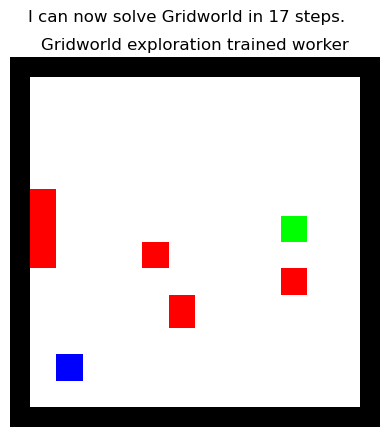

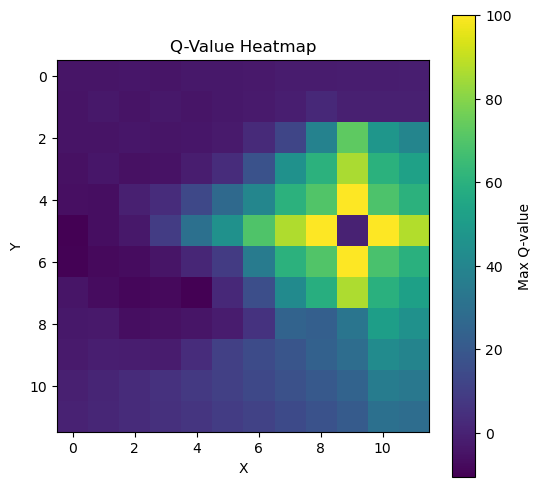

In [33]:
value_map = np.zeros((agent.sizeY, agent.sizeX))
for x in range(agent.sizeX):
    for y in range(agent.sizeY):
        state = (x, y)
        best_q = max(Q[state].values())
        value_map[y, x] = best_q  # note: row = y, col = x
plt.figure(figsize=(6, 6))
plt.imshow(value_map, cmap='viridis')
plt.colorbar(label='Max Q-value')
plt.title('Q-Value Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()


## Try to extract the best move per state from Q

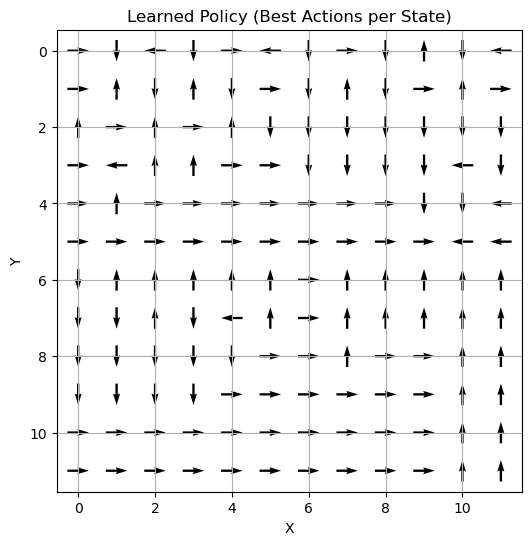

In [35]:
import matplotlib.pyplot as plt

arrow_dict = {0: (0, -1), 1: (0, 1), 2: (-1, 0), 3: (1, 0)}  # up, down, left, right

U = np.zeros((agent.sizeY, agent.sizeX))
V = np.zeros((agent.sizeY, agent.sizeX))

for x in range(agent.sizeX):
    for y in range(agent.sizeY):
        state = (x, y)
        best_action = get_best_action(Q[state])[0]
        dx, dy = arrow_dict[best_action]
        U[y, x] = dx
        V[y, x] = -dy  # minus because y=0 is top in matplotlib
plt.figure(figsize=(6, 6))
plt.quiver(U, V, pivot='middle')
plt.title("Learned Policy (Best Actions per State)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


# Problem X: Shaping Random Points

Episode 0, Loss: 0.8537
Episode 100, Loss: 0.0014
Episode 200, Loss: 0.0011
Episode 300, Loss: 0.0002
Episode 400, Loss: 0.0001
Episode 500, Loss: 0.0001
Episode 600, Loss: 0.0000
Episode 700, Loss: 0.0000
Episode 800, Loss: 0.0001
Episode 900, Loss: 0.0001
Episode 1000, Loss: 0.0001
Episode 1100, Loss: 0.0000
Episode 1200, Loss: 0.0304
Episode 1300, Loss: 0.0123
Episode 1400, Loss: 0.0002
Episode 1500, Loss: 0.0001
Episode 1600, Loss: 0.0001
Episode 1700, Loss: 0.0000
Episode 1800, Loss: 0.0000
Episode 1900, Loss: 0.0000
Episode 2000, Loss: 0.0000
Episode 2100, Loss: 0.0000
Episode 2200, Loss: 0.0000
Episode 2300, Loss: 0.0000
Episode 2400, Loss: 0.0000
Episode 2500, Loss: 0.0000
Episode 2600, Loss: 0.0000
Episode 2700, Loss: 0.0000
Episode 2800, Loss: 0.0000
Episode 2900, Loss: 0.0000
Episode 3000, Loss: 0.0000
Episode 3100, Loss: 0.0000
Episode 3200, Loss: 0.0000
Episode 3300, Loss: 0.0000
Episode 3400, Loss: 0.0000
Episode 3500, Loss: 0.0001
Episode 3600, Loss: 0.0001
Episode 3700,

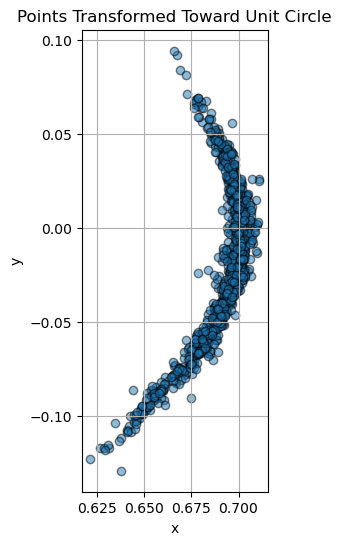

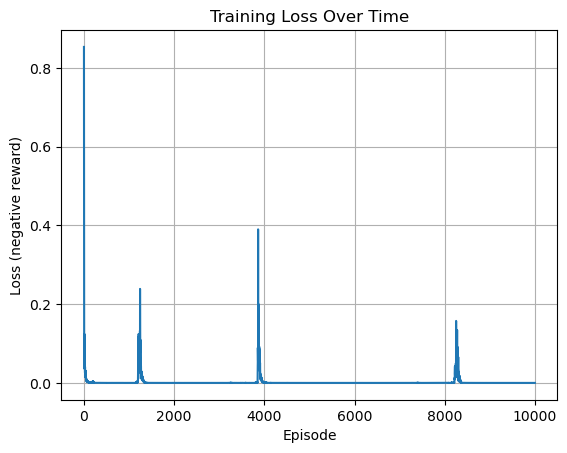

In [47]:
# Reinforcement Learning for Shaping Random Points

# Step 1: Imports and Setup

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Step 2: Define the Policy Network

class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output delta x and delta y
        )

    def forward(self, x):
        return self.net(x)

# Step 3: Define the Environment and Reward Function
# We use the unit circle as the target shape.

def reward_circle(point):
    r = torch.norm(point, dim=1)
    return -((r - 1.0)**2)  # Max reward at r=1

def reward_square(point):
    x = point[:, 0]
    y = point[:, 1]

    # Distance to each edge
    dist_top = (y - 1).abs()
    dist_bottom = (y + 1).abs()
    dist_left = (x + 1).abs()
    dist_right = (x - 1).abs()

    # Penalize distance to the *closest* edge
    edge_dist = torch.min(torch.stack([dist_top, dist_bottom, dist_left, dist_right], dim=1), dim=1).values

    # Also penalize if outside bounds (keep points close to the square)
    out_of_bounds = torch.relu(x.abs() - 1) + torch.relu(y.abs() - 1)

    return -(edge_dist + out_of_bounds)  # Negative = loss, reward is highest at edge

def reward_four_leaf_clover(point):
    # Convert to polar coordinates
    r = torch.norm(point, dim=1)
    theta = torch.atan2(point[:, 1], point[:, 0])
    
    # Four-leaf clover pattern
    # This uses a polar equation r = a + b*cos(2*theta)
    # The 2*theta gives us 4 lobes
    lobe_size = 0.5
    base_r = 0.2
    target_r = base_r + lobe_size * torch.cos(2 * theta) * torch.cos(2 * theta)
    
    # Reward is highest when points are at the target radius for their angle
    reward = -((r - target_r)**2)
    
    return reward

def reward_swiss_cross(point):
    x = point[:, 0]
    y = point[:, 1]

    bar_width = 0.2

    # Penalize distance to the horizontal and vertical bars
    dist_to_vert = torch.relu(x.abs() - bar_width)
    dist_to_horiz = torch.relu(y.abs() - bar_width)

    # Reward for being close to either bar (closer = better)
    dist = torch.min(dist_to_vert, dist_to_horiz)

    # Also encourage being within bounds
    radius_penalty = 0.05 * (x**2 + y**2)

    return -(dist + radius_penalty)

# Step 4: Training Loop (REINFORCE-style)

policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=0.01)

num_episodes = 10000
batch_size = 128
loss_history = []

for episode in range(num_episodes):
    # Sample random 2D points (state) and their mirror images
    half = batch_size // 2
    half_state = torch.randn(half, 2)
    state = torch.cat([half_state, -half_state], dim=0)

    # Predict action: a displacement vector
    action = policy(state)
    
    # Apply action
    moved = state + action

    # Get reward
    reward = reward_four_leaf_clover(moved)

    # Compute loss (REINFORCE trick)
    loss = -reward.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if episode % 100 == 0:
        print(f"Episode {episode}, Loss: {loss.item():.4f}")

# Step 5: Visualize the Learned Shape

# Generate and transform test points
with torch.no_grad():
    test_points = torch.randn(1000, 2)
    transformed = test_points + policy(test_points)
    
    transformed = transformed.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, edgecolor='k')
plt.title("Points Transformed Toward Unit Circle")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

# Step 6: Plot Training Loss

plt.plot(loss_history)
plt.title("Training Loss Over Time")
plt.xlabel("Episode")
plt.ylabel("Loss (negative reward)")
plt.grid(True)
plt.show()


In [49]:
# Improved Reinforcement Learning for Shaping Random Points
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

# Set reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Create directory for visualizations
os.makedirs("shape_viz", exist_ok=True)

# Define an improved Policy Network with batch normalization
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# Define various reward functions for different shapes
class ShapeRewards:
    @staticmethod
    def circle(point):
        r = torch.norm(point, dim=1)
        return -((r - 1.0)**2)  # Max reward at r=1
    
    @staticmethod
    def square(point):
        x = point[:, 0]
        y = point[:, 1]
        # Distance to each edge
        dist_top = (y - 1).abs()
        dist_bottom = (y + 1).abs()
        dist_left = (x + 1).abs()
        dist_right = (x - 1).abs()
        # Penalize distance to the closest edge
        edge_dist = torch.min(torch.stack([dist_top, dist_bottom, dist_left, dist_right], dim=1), dim=1).values
        # Also penalize if outside bounds (keep points close to the square)
        out_of_bounds = torch.relu(x.abs() - 1) + torch.relu(y.abs() - 1)
        return -(edge_dist + out_of_bounds)
    
    @staticmethod
    def swiss_cross(point):
        x = point[:, 0]
        y = point[:, 1]
        bar_width = 0.2
        # Penalize distance to the horizontal and vertical bars
        dist_to_vert = torch.relu(x.abs() - bar_width)
        dist_to_horiz = torch.relu(y.abs() - bar_width)
        # Reward for being close to either bar (closer = better)
        dist = torch.min(dist_to_vert, dist_to_horiz)
        # Also encourage being within bounds
        radius_penalty = 0.05 * (x**2 + y**2)
        return -(dist + radius_penalty)
    
    @staticmethod
    def star(point):
        # Convert to polar coordinates
        r = torch.norm(point, dim=1)
        theta = torch.atan2(point[:, 1], point[:, 0])
        
        # Number of points in the star
        n_points = 5
        
        # Modulate the radius based on angle to create star points
        # cos(n*theta) creates n peaks as theta goes around the circle
        target_r = 0.4 + 0.6 * torch.cos(n_points * theta)
        
        # Reward is highest when points are at the target radius for their angle
        distance = (r - target_r).abs()
        reward = -(distance**2)
        
        # Add penalty for points too far away
        max_distance = 2.0
        far_penalty = torch.relu(r - max_distance) * 5.0
        
        return reward - far_penalty
    
    @staticmethod
    def four_leaf_clover(point):
        # Convert to polar coordinates
        r = torch.norm(point, dim=1)
        theta = torch.atan2(point[:, 1], point[:, 0])
        
        # Modified equation - using absolute cosine for sharper lobes
        lobe_size = 0.7
        base_r = 0.3
        # This formula creates more distinct lobes
        target_r = base_r + lobe_size * torch.abs(torch.cos(2 * theta))
        
        # Steeper reward function with stronger gradient
        distance = (r - target_r).abs()
        reward = -(distance**2)
        
        # Add penalty for points too far away to encourage convergence
        max_distance = 2.0
        far_penalty = torch.relu(r - max_distance) * 5.0
        
        return reward - far_penalty

# Visualization function to monitor training progress
def visualize_current_state(policy, episode, shape_name):
    with torch.no_grad():
        test_points = torch.randn(1000, 2)
        transformed = test_points + policy(test_points)
        
        # Apply normalization to keep points in view
        max_radius = 3.0
        norm = torch.norm(transformed, dim=1, keepdim=True)
        too_far_mask = norm > max_radius
        if too_far_mask.any():
            transformed[too_far_mask] = transformed[too_far_mask] / norm[too_far_mask] * max_radius
            
        transformed = transformed.numpy()
        
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, s=10, c='blue', edgecolor='none')
    plt.title(f"{shape_name} Shape at Episode {episode}")
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.savefig(f"shape_viz/{shape_name}_episode_{episode}.png")
    plt.close()

# Main training function
def train_shape_policy(reward_function, shape_name, num_episodes=5000, batch_size=128, 
                       learning_rate=0.005, visualize_every=500):
    policy = PolicyNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=200, verbose=True
    )
    
    # For early stopping
    patience = 300
    min_loss = float('inf')
    patience_counter = 0
    
    loss_history = []
    
    print(f"Starting training for {shape_name} shape...")
    
    for episode in range(num_episodes):
        # Sample random 2D points (state) and their mirror images for symmetry
        half = batch_size // 2
        half_state = torch.randn(half, 2)
        state = torch.cat([half_state, -half_state], dim=0)
        
        # Predict action: a displacement vector
        action = policy(state)
        
        # Apply action
        moved = state + action
        
        # Apply normalization to keep points from drifting too far
        max_radius = 2.0
        norm = torch.norm(moved, dim=1, keepdim=True)
        too_far_mask = norm > max_radius
        if too_far_mask.any():
            moved[too_far_mask] = moved[too_far_mask] / norm[too_far_mask] * max_radius
        
        # Get reward
        reward = reward_function(moved)
        
        # Compute loss (REINFORCE trick)
        loss = -reward.mean()
        
        optimizer.zero_grad()
        loss.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)
        
        loss_history.append(loss.item())
        
        # Early stopping check
        if loss.item() < min_loss:
            min_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at episode {episode}")
            break
        
        # Progress reporting and visualization
        if episode % 100 == 0:
            print(f"Episode {episode}, Loss: {loss.item():.4f}")
        
        if episode % visualize_every == 0 or episode == num_episodes - 1:
            visualize_current_state(policy, episode, shape_name)
    
    # Final visualization with more points
    print(f"Finished training for {shape_name} shape!")
    visualize_current_state(policy, num_episodes, f"{shape_name}_final")
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title(f"Training Loss Over Time - {shape_name}")
    plt.xlabel("Episode")
    plt.ylabel("Loss (negative reward)")
    plt.grid(True)
    plt.savefig(f"shape_viz/{shape_name}_loss.png")
    plt.close()
    
    return policy, loss_history

# Example usage
if __name__ == "__main__":
    # Select which shape to train
    shape = "clover"  # Options: "circle", "square", "swiss_cross", "star", "clover"
    
    if shape == "circle":
        reward_func = ShapeRewards.circle
    elif shape == "square":
        reward_func = ShapeRewards.square
    elif shape == "swiss_cross":
        reward_func = ShapeRewards.swiss_cross
    elif shape == "star":
        reward_func = ShapeRewards.star
    elif shape == "clover":
        reward_func = ShapeRewards.four_leaf_clover
    else:
        raise ValueError(f"Unknown shape: {shape}")
    
    # Train the policy
    trained_policy, loss_history = train_shape_policy(
        reward_func, 
        shape_name=shape,
        num_episodes=5000,
        batch_size=256,  # Increased batch size
        learning_rate=0.005,
        visualize_every=500
    )
    
    # Generate and save final result
    with torch.no_grad():
        test_points = torch.randn(2000, 2)  # More test points
        transformed = test_points + trained_policy(test_points)
        transformed = transformed.numpy()
    
    plt.figure(figsize=(10, 10))
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, s=5, c='blue', edgecolor='none')
    plt.title(f"Final {shape.capitalize()} Shape")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.savefig(f"shape_viz/{shape}_final_result.png")
    plt.show()

C:\Users\tomke\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Starting training for clover shape...


IndexError: The shape of the mask [256, 1] at index 1 does not match the shape of the indexed tensor [256, 2] at index 1

In [51]:
# Improved Reinforcement Learning for Shaping Random Points
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

# Set reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Create directory for visualizations
os.makedirs("shape_viz", exist_ok=True)

# Define an improved Policy Network with batch normalization
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# Define various reward functions for different shapes
class ShapeRewards:
    @staticmethod
    def circle(point):
        r = torch.norm(point, dim=1)
        return -((r - 1.0)**2)  # Max reward at r=1
    
    @staticmethod
    def square(point):
        x = point[:, 0]
        y = point[:, 1]
        # Distance to each edge
        dist_top = (y - 1).abs()
        dist_bottom = (y + 1).abs()
        dist_left = (x + 1).abs()
        dist_right = (x - 1).abs()
        # Penalize distance to the closest edge
        edge_dist = torch.min(torch.stack([dist_top, dist_bottom, dist_left, dist_right], dim=1), dim=1).values
        # Also penalize if outside bounds (keep points close to the square)
        out_of_bounds = torch.relu(x.abs() - 1) + torch.relu(y.abs() - 1)
        return -(edge_dist + out_of_bounds)
    
    @staticmethod
    def swiss_cross(point):
        x = point[:, 0]
        y = point[:, 1]
        bar_width = 0.2
        # Penalize distance to the horizontal and vertical bars
        dist_to_vert = torch.relu(x.abs() - bar_width)
        dist_to_horiz = torch.relu(y.abs() - bar_width)
        # Reward for being close to either bar (closer = better)
        dist = torch.min(dist_to_vert, dist_to_horiz)
        # Also encourage being within bounds
        radius_penalty = 0.05 * (x**2 + y**2)
        return -(dist + radius_penalty)
    
    @staticmethod
    def star(point):
        # Convert to polar coordinates
        r = torch.norm(point, dim=1)
        theta = torch.atan2(point[:, 1], point[:, 0])
        
        # Number of points in the star
        n_points = 5
        
        # Modulate the radius based on angle to create star points
        # cos(n*theta) creates n peaks as theta goes around the circle
        target_r = 0.4 + 0.6 * torch.cos(n_points * theta)
        
        # Reward is highest when points are at the target radius for their angle
        distance = (r - target_r).abs()
        reward = -(distance**2)
        
        # Add penalty for points too far away
        max_distance = 2.0
        far_penalty = torch.relu(r - max_distance) * 5.0
        
        return reward - far_penalty
    
    @staticmethod
    def four_leaf_clover(point):
        # Convert to polar coordinates
        r = torch.norm(point, dim=1)
        theta = torch.atan2(point[:, 1], point[:, 0])
        
        # Modified equation - using absolute cosine for sharper lobes
        lobe_size = 0.7
        base_r = 0.3
        # This formula creates more distinct lobes
        target_r = base_r + lobe_size * torch.abs(torch.cos(2 * theta))
        
        # Steeper reward function with stronger gradient
        distance = (r - target_r).abs()
        reward = -(distance**2)
        
        # Add penalty for points too far away to encourage convergence
        max_distance = 2.0
        far_penalty = torch.relu(r - max_distance) * 5.0
        
        return reward - far_penalty

# Visualization function to monitor training progress
def visualize_current_state(policy, episode, shape_name):
    with torch.no_grad():
        test_points = torch.randn(1000, 2)
        transformed = test_points + policy(test_points)
        
        # Apply normalization to keep points in view
        max_radius = 3.0
        norm = torch.norm(transformed, dim=1, keepdim=True)
        too_far_mask = (norm > max_radius).squeeze()
        if too_far_mask.any():
            transformed[too_far_mask] = transformed[too_far_mask] / norm[too_far_mask] * max_radius
            
        transformed = transformed.numpy()
        
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, s=10, c='blue', edgecolor='none')
    plt.title(f"{shape_name} Shape at Episode {episode}")
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.savefig(f"shape_viz/{shape_name}_episode_{episode}.png")
    plt.close()

# Main training function
def train_shape_policy(reward_function, shape_name, num_episodes=5000, batch_size=128, 
                       learning_rate=0.005, visualize_every=500):
    policy = PolicyNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=200, verbose=True
    )
    
    # For early stopping
    patience = 300
    min_loss = float('inf')
    patience_counter = 0
    
    loss_history = []
    
    print(f"Starting training for {shape_name} shape...")
    
    for episode in range(num_episodes):
        # Sample random 2D points (state) and their mirror images for symmetry
        half = batch_size // 2
        half_state = torch.randn(half, 2)
        state = torch.cat([half_state, -half_state], dim=0)
        
        # Predict action: a displacement vector
        action = policy(state)
        
        # Apply action
        moved = state + action
        
        # Apply normalization to keep points from drifting too far
        max_radius = 2.0
        norm = torch.norm(moved, dim=1, keepdim=True)
        too_far_mask = (norm > max_radius).squeeze()
        if too_far_mask.any():
            moved[too_far_mask] = moved[too_far_mask] / norm[too_far_mask] * max_radius
        
        # Get reward
        reward = reward_function(moved)
        
        # Compute loss (REINFORCE trick)
        loss = -reward.mean()
        
        optimizer.zero_grad()
        loss.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)
        
        loss_history.append(loss.item())
        
        # Early stopping check
        if loss.item() < min_loss:
            min_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at episode {episode}")
            break
        
        # Progress reporting and visualization
        if episode % 100 == 0:
            print(f"Episode {episode}, Loss: {loss.item():.4f}")
        
        if episode % visualize_every == 0 or episode == num_episodes - 1:
            visualize_current_state(policy, episode, shape_name)
    
    # Final visualization with more points
    print(f"Finished training for {shape_name} shape!")
    visualize_current_state(policy, num_episodes, f"{shape_name}_final")
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title(f"Training Loss Over Time - {shape_name}")
    plt.xlabel("Episode")
    plt.ylabel("Loss (negative reward)")
    plt.grid(True)
    plt.savefig(f"shape_viz/{shape_name}_loss.png")
    plt.close()
    
    return policy, loss_history

# Example usage
if __name__ == "__main__":
    # Select which shape to train
    shape = "clover"  # Options: "circle", "square", "swiss_cross", "star", "clover"
    
    if shape == "circle":
        reward_func = ShapeRewards.circle
    elif shape == "square":
        reward_func = ShapeRewards.square
    elif shape == "swiss_cross":
        reward_func = ShapeRewards.swiss_cross
    elif shape == "star":
        reward_func = ShapeRewards.star
    elif shape == "clover":
        reward_func = ShapeRewards.four_leaf_clover
    else:
        raise ValueError(f"Unknown shape: {shape}")
    
    # Train the policy
    trained_policy, loss_history = train_shape_policy(
        reward_func, 
        shape_name=shape,
        num_episodes=5000,
        batch_size=256,  # Increased batch size
        learning_rate=0.005,
        visualize_every=500
    )
    
    # Generate and save final result
    with torch.no_grad():
        test_points = torch.randn(2000, 2)  # More test points
        transformed = test_points + trained_policy(test_points)
        transformed = transformed.numpy()
    
    plt.figure(figsize=(10, 10))
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, s=5, c='blue', edgecolor='none')
    plt.title(f"Final {shape.capitalize()} Shape")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.savefig(f"shape_viz/{shape}_final_result.png")
    plt.show()

Starting training for clover shape...


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [256, 2]], which is output 0 of IndexPutBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).